In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [5]:
df = pd.read_csv('/content/adult.csv')
print(f"Dataset shape: {df.shape}")
print(df.head())

Dataset shape: (48842, 15)
   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-pe


Missing values after cleaning:
 age                   0
workclass          2795
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2805
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      856
income                0
dtype: int64


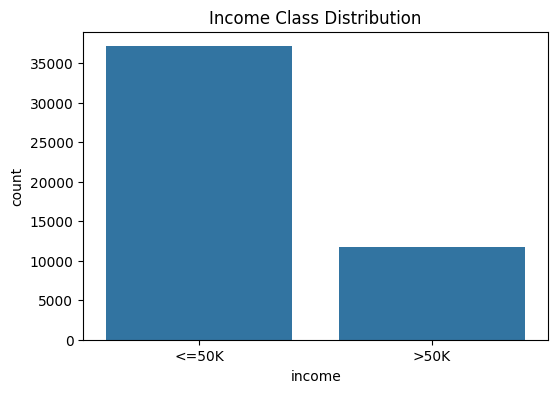

In [6]:
#cleaningg
df.replace('?', np.nan, inplace=True)

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()

df.drop_duplicates(inplace=True)

df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int)

df.dropna(subset=['income'], inplace=True)

print("\nMissing values after cleaning:\n", df.isnull().sum())

plt.figure(figsize=(6,4))
sns.countplot(x='income', data=df)
plt.title("Income Class Distribution")
plt.xticks([0,1], ['<=50K', '>50K'])
plt.show()

In [7]:
X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (39032, 14), Test shape: (9758, 14)


In [8]:
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [9]:
#pre-processing, encoding & imputing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [10]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

models = {
    "Logistic Regression (Balanced)": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
    ]),
    "Random Forest (SMOTE)": ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    "XGBoost (SMOTE)": ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ])
}

In [11]:
results = {}

#model training
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    }

results_df = pd.DataFrame(results).T.sort_values(by="ROC AUC", ascending=False)
print("\n--- Model Performance Comparison ---")
print(results_df)

#best model
best_model_name = results_df.index[0]
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")


Training Logistic Regression (Balanced)...

Training Random Forest (SMOTE)...

Training XGBoost (SMOTE)...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:22:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Model Performance Comparison ---
                                Accuracy  F1-Score   ROC AUC
XGBoost (SMOTE)                 0.855503  0.714921  0.919718
Logistic Regression (Balanced)  0.805185  0.676095  0.903337
Random Forest (SMOTE)           0.841668  0.681771  0.896961

Best model: XGBoost (SMOTE)


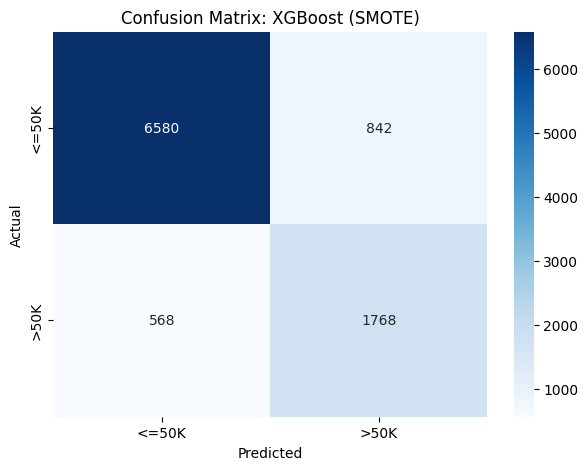

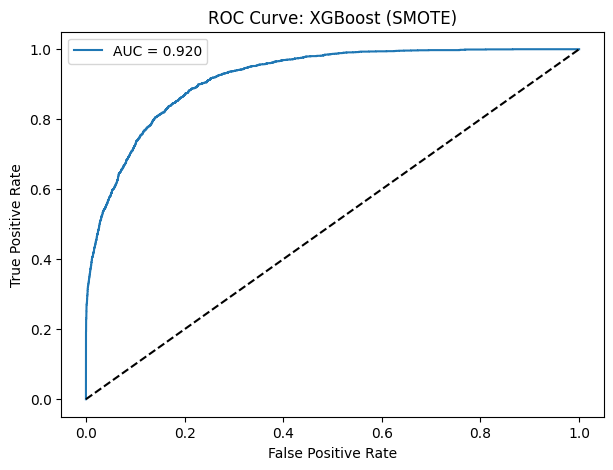

In [12]:
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

#confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix: {best_model_name}')
plt.show()

#roc curve
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
auc_score = roc_auc_score(y_test, y_proba_best)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: {best_model_name}')
plt.legend()
plt.show()

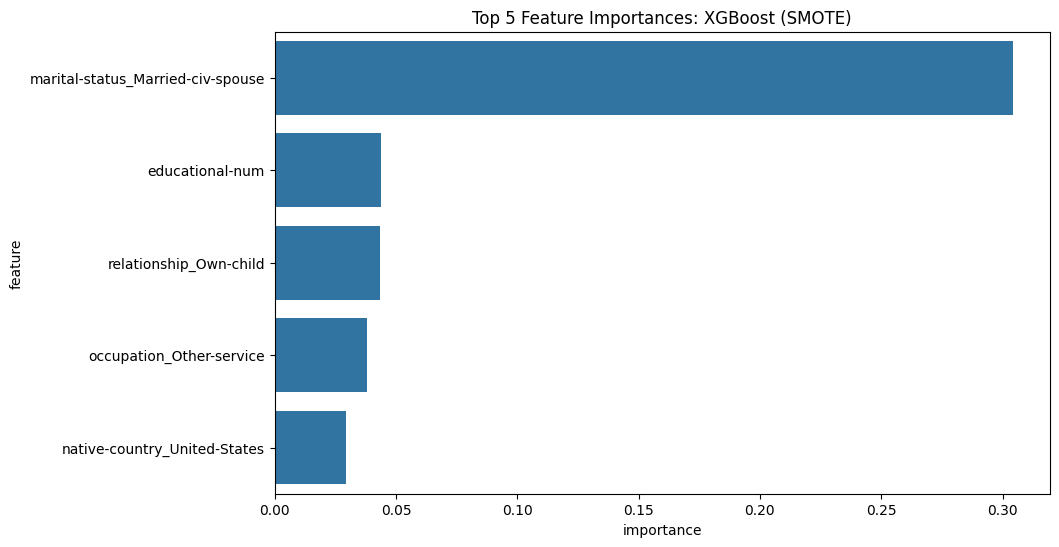

In [13]:
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    classifier_viz = best_model.named_steps['classifier']
    preprocessor_viz = best_model.named_steps['preprocessor']

    ohe = preprocessor_viz.transformers_[1][1].named_steps['onehot']
    ohe_feature_names = ohe.get_feature_names_out(categorical_features)
    all_feature_names = numeric_features + list(ohe_feature_names)

    importances = classifier_viz.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False).head(5)

    plt.figure(figsize=(10,6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title(f'Top 5 Feature Importances: {best_model_name}')
    plt.show()